# Comparação de 3 métodos de seleção de variáveis

In [1]:
#Importar pacotes
import pandas as pd
import numpy as np
import csv as csv

from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier

#Shuffle the datasets
from sklearn.utils import shuffle

#Learning curve
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
from sklearn.utils import shuffle
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from imblearn.over_sampling import SMOTE

from sklearn.decomposition import PCA

import tensorflow as tf
import math
from tensorflow.python.framework import ops
import time
%matplotlib inline
import seaborn as sns
from sklearn.metrics import accuracy_score, f1_score , precision_score, recall_score, roc_auc_score
#metrics.roc_auc_score(y_true, y_score[, …])
sns.set(style="ticks")
plt.rcParams['figure.figsize'] = (16.0, 10.0)
plt.style.use('seaborn-colorblind')

In [2]:
#Lendo os dados

    
path = 'data.csv'


data = pd.read_csv(path, sep=";",header=1)
data.columns
#print(lumns)
#data = DataFramedata.drop(data.index[0])
#data.head()
#data.isnull().sum()
data_adj = data.drop(['ID'],axis=1)

In [3]:
#número de clientes que deram default nessa base de dados
print('a proporção de clientes que deu default nessa base de dados é de: ',data_adj['default payment next month'].sum()/len(data_adj))


a proporção de clientes que deu default nessa base de dados é de:  0.2212


In [4]:
#Verificando valores nulos na base de dados
print(data_adj.isnull().sum())

#Criando dummies para as variáveis categóricas: SEX, EDUCATION e MARRIAGE
cols_dummy = ['SEX','EDUCATION','MARRIAGE']
data_adj = pd.get_dummies(data_adj,dummy_na=False,columns=cols_dummy,drop_first=True)



LIMIT_BAL                     0
SEX                           0
EDUCATION                     0
MARRIAGE                      0
AGE                           0
PAY_0                         0
PAY_2                         0
PAY_3                         0
PAY_4                         0
PAY_5                         0
PAY_6                         0
BILL_AMT1                     0
BILL_AMT2                     0
BILL_AMT3                     0
BILL_AMT4                     0
BILL_AMT5                     0
BILL_AMT6                     0
PAY_AMT1                      0
PAY_AMT2                      0
PAY_AMT3                      0
PAY_AMT4                      0
PAY_AMT5                      0
PAY_AMT6                      0
default payment next month    0
dtype: int64


In [5]:
#Pela documetação, A variável PAY_0 ... PAY_6 indica o número de meses em atrado de cada uma das faturas de até 6 meses atrás.
# Provavelmente por erro na base, não temos a variável PAY_1.

#Precisamos transformar esses valores em dummies.
#Vamos avaliar como os valores dessa variável se comportam comparando com a variável target para definir os pontos de corte
print(data_adj[["PAY_0", "default payment next month"]].groupby(["PAY_0"], as_index=False).mean().sort_values(by='PAY_0', ascending=False))
print(data_adj[["PAY_2", "default payment next month"]].groupby(["PAY_2"], as_index=False).mean().sort_values(by='PAY_2', ascending=False))
print(data_adj[["PAY_3", "default payment next month"]].groupby(["PAY_3"], as_index=False).mean().sort_values(by='PAY_3', ascending=False))
print(data_adj[["PAY_4", "default payment next month"]].groupby(["PAY_4"], as_index=False).mean().sort_values(by='PAY_4', ascending=False))
print(data_adj[["PAY_5", "default payment next month"]].groupby(["PAY_5"], as_index=False).mean().sort_values(by='PAY_5', ascending=False))
print(data_adj[["PAY_6", "default payment next month"]].groupby(["PAY_6"], as_index=False).mean().sort_values(by='PAY_6', ascending=False))


    PAY_0  default payment next month
10      8                    0.578947
9       7                    0.777778
8       6                    0.545455
7       5                    0.500000
6       4                    0.684211
5       3                    0.757764
4       2                    0.691414
3       1                    0.339479
2       0                    0.128113
1      -1                    0.167781
0      -2                    0.132294
    PAY_2  default payment next month
10      8                    0.000000
9       7                    0.600000
8       6                    0.750000
7       5                    0.600000
6       4                    0.505051
5       3                    0.616564
4       2                    0.556150
3       1                    0.178571
2       0                    0.159123
1      -1                    0.159669
0      -2                    0.182708
    PAY_3  default payment next month
10      8                    0.666667
9       7   

In [6]:
pay_columns = ['PAY_0','PAY_2','PAY_3','PAY_4','PAY_5','PAY_6']
for i in pay_columns:
    data_adj[str(i)+str('_dully')]= data_adj[i].apply(lambda x:1 if x < 1 else 0)
    data_adj[str(i)+str('_miss')]= data_adj[i].apply(lambda x:1 if x == 1 else 0)
    data_adj[str(i)+str('_late')]= data_adj[i].apply(lambda x:1 if x > 1 else 0)
    data_adj = data_adj.drop([str(i)],axis=1)


In [7]:
print(data_adj.columns)

Index(['LIMIT_BAL', 'AGE', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4',
       'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3',
       'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6', 'default payment next month',
       'SEX_2', 'EDUCATION_1', 'EDUCATION_2', 'EDUCATION_3', 'EDUCATION_4',
       'EDUCATION_5', 'EDUCATION_6', 'MARRIAGE_1', 'MARRIAGE_2', 'MARRIAGE_3',
       'PAY_0_dully', 'PAY_0_miss', 'PAY_0_late', 'PAY_2_dully', 'PAY_2_miss',
       'PAY_2_late', 'PAY_3_dully', 'PAY_3_miss', 'PAY_3_late', 'PAY_4_dully',
       'PAY_4_miss', 'PAY_4_late', 'PAY_5_dully', 'PAY_5_miss', 'PAY_5_late',
       'PAY_6_dully', 'PAY_6_miss', 'PAY_6_late'],
      dtype='object')


# Feature Engineering

In [8]:
#data_adj2= data_adj

In [9]:
BA_columns = ['BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4','BILL_AMT5', 'BILL_AMT6']
PA_columns = ['PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3','PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']


for i in BA_columns:
    for j in PA_columns:
        data_adj[str('PAY_TOT_')+str(i[-4:])] = data_adj[i]>data_adj[j]
        
for i in BA_columns:
    data_adj[str('BilltoLIMIT_')+str(i[-4:])] = data_adj[i]/data_adj['LIMIT_BAL']
    # O menor LIMIT_BAL da base é 10k, portanto não teremos problemas com essa divisão.
        
for i in BA_columns:
    for j in PA_columns:
        data_adj[str('DUEtoBILL')+str(i[-4:])] = ((data_adj[i]-data_adj[j])/(data_adj[i]+0.000001)) * data_adj[str('PAY_TOT_')+str(i[-4:])]
        # A multiplicação final: Só vamos calcular essa variável para os clientes que não pagaram a fatura total.
        data_adj[str('DUEtoBILL2')+str(i[-4:])] = data_adj[str('DUEtoBILL')+str(i[-4:])]**2
        #Variável ao quadrado
        

In [10]:
data_adj.describe()

,LIMIT_BAL,AGE,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,...,DUEtoBILLAMT2,DUEtoBILL2AMT2,DUEtoBILLAMT3,DUEtoBILL2AMT3,DUEtoBILLAMT4,DUEtoBILL2AMT4,DUEtoBILLAMT5,DUEtoBILL2AMT5,DUEtoBILLAMT6,DUEtoBILL2AMT6
count,30000.000000,30000.000000,30000.000000,30000.000000,3.000000e+04,30000.000000,30000.000000,30000.000000,30000.000000,3.000000e+04,...,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000
mean,167484.322667,35.485500,51223.330900,49179.075167,4.701315e+04,43262.948967,40311.400967,38871.760400,5663.580500,5.921163e+03,...,0.709143,0.663579,0.694493,0.648713,0.680047,0.633373,0.660811,0.614354,0.638751,0.592825
std,129747.661567,9.217904,73635.860576,71173.768783,6.934939e+04,64332.856134,60797.155770,59554.107537,16563.280354,2.304087e+04,...,0.400875,0.403394,0.407919,0.408241,0.413419,0.411908,0.421531,0.417431,0.429917,0.423290
min,10000.000000,21.000000,-165580.000000,-69777.000000,-1.572640e+05,-170000.000000,-81334.000000,-339603.000000,0.000000,0.000000e+00,...,-0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,50000.000000,28.000000,3558.750000,2984.750000,2.666250e+03,2326.750000,1763.000000,1256.000000,1000.000000,8.330000e+02,...,0.444331,0.197430,0.310413,0.096356,0.158795,0.025216,0.000000,0.000000,0.000000,0.000000
50%,140000.000000,34.000000,22381.500000,21200.000000,2.008850e+04,19052.000000,18104.500000,17071.000000,2100.000000,2.009000e+03,...,0.953703,0.909550,0.950319,0.903106,0.946058,0.895025,0.941513,0.886447,0.933888,0.872146
75%,240000.000000,41.000000,67091.000000,64006.250000,6.016475e+04,54506.000000,50190.500000,49198.250000,5006.000000,5.000000e+03,...,0.979959,0.960320,0.976486,0.953524,0.970597,0.942059,0.965726,0.932626,0.964009,0.929314
max,1000000.000000,79.000000,964511.000000,983931.000000,1.664089e+06,891586.000000,927171.000000,961664.000000,873552.000000,1.684259e+06,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [11]:
#Separando Train e Test Set
data_Y = pd.DataFrame(np.reshape(data_adj['default payment next month'],(len(data_adj['default payment next month']),1)),columns=['target'])

data_X = data_adj.drop('default payment next month',axis=1)

from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(data_X,data_Y,test_size=0.3,random_state=42)

C:\Users\Rodrigo\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:57: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


In [12]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
replacement_columns = ['LIMIT_BAL', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4','BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3','PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']

X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train[replacement_columns]),columns=X_train[replacement_columns].columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test[replacement_columns]),columns=X_train[replacement_columns].columns)

In [13]:
#Reset index
X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
X_train_scaled = X_train_scaled.reset_index(drop=True)
X_test_scaled =X_train_scaled.reset_index(drop=True)

In [14]:
replacement_columns = ['LIMIT_BAL', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4','BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3','PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']

#X_train.drop(replacement_columns,axis=1)
#X_test.drop(replacement_columns,axis=1)

for i in replacement_columns:
    X_train = X_train.drop([i],axis=1)
    X_test = X_test.drop([i],axis=1)
    X_train[i] = X_train_scaled[i]
    X_test[i] = X_test_scaled[i]

In [15]:
X_train.columns

Index(['AGE', 'SEX_2', 'EDUCATION_1', 'EDUCATION_2', 'EDUCATION_3',
       'EDUCATION_4', 'EDUCATION_5', 'EDUCATION_6', 'MARRIAGE_1', 'MARRIAGE_2',
       'MARRIAGE_3', 'PAY_0_dully', 'PAY_0_miss', 'PAY_0_late', 'PAY_2_dully',
       'PAY_2_miss', 'PAY_2_late', 'PAY_3_dully', 'PAY_3_miss', 'PAY_3_late',
       'PAY_4_dully', 'PAY_4_miss', 'PAY_4_late', 'PAY_5_dully', 'PAY_5_miss',
       'PAY_5_late', 'PAY_6_dully', 'PAY_6_miss', 'PAY_6_late', 'PAY_TOT_AMT1',
       'PAY_TOT_AMT2', 'PAY_TOT_AMT3', 'PAY_TOT_AMT4', 'PAY_TOT_AMT5',
       'PAY_TOT_AMT6', 'BilltoLIMIT_AMT1', 'BilltoLIMIT_AMT2',
       'BilltoLIMIT_AMT3', 'BilltoLIMIT_AMT4', 'BilltoLIMIT_AMT5',
       'BilltoLIMIT_AMT6', 'DUEtoBILLAMT1', 'DUEtoBILL2AMT1', 'DUEtoBILLAMT2',
       'DUEtoBILL2AMT2', 'DUEtoBILLAMT3', 'DUEtoBILL2AMT3', 'DUEtoBILLAMT4',
       'DUEtoBILL2AMT4', 'DUEtoBILLAMT5', 'DUEtoBILL2AMT5', 'DUEtoBILLAMT6',
       'DUEtoBILL2AMT6', 'LIMIT_BAL', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3',
       'BILL_AMT4', 'BILL

In [16]:
#Checking some columns
#X_train[replacement_columns].describe().astype(int)
# New dummies
a = ['PAY_0_dully', 'PAY_0_miss', 'PAY_0_late', 'PAY_2_dully',
       'PAY_2_miss', 'PAY_2_late', 'PAY_3_dully', 'PAY_3_miss', 'PAY_3_late',
       'PAY_4_dully', 'PAY_4_miss', 'PAY_4_late', 'PAY_5_dully', 'PAY_5_miss',
       'PAY_5_late', 'PAY_6_dully', 'PAY_6_miss', 'PAY_6_late']
X_train[a].describe().astype(int)
a = ['PAY_5_miss','PAY_6_miss']
#Pay_5_miss and Pay_6_miss are full zeros. Lets drop them
for i in a:
    X_train = X_train.drop([i],axis=1)
    X_test = X_test.drop([i],axis=1)


In [17]:
a = ['BilltoLIMIT_AMT1', 'BilltoLIMIT_AMT2','BilltoLIMIT_AMT3', 'BilltoLIMIT_AMT4', 'BilltoLIMIT_AMT5',
       'BilltoLIMIT_AMT6', 'DUEtoBILLAMT1', 'DUEtoBILL2AMT1', 'DUEtoBILLAMT2',
       'DUEtoBILL2AMT2', 'DUEtoBILLAMT3', 'DUEtoBILL2AMT3', 'DUEtoBILLAMT4',
       'DUEtoBILL2AMT4', 'DUEtoBILLAMT5', 'DUEtoBILL2AMT5', 'DUEtoBILLAMT6',
       'DUEtoBILL2AMT6']

X_train[a].describe().astype(float)


,BilltoLIMIT_AMT1,BilltoLIMIT_AMT2,BilltoLIMIT_AMT3,BilltoLIMIT_AMT4,BilltoLIMIT_AMT5,BilltoLIMIT_AMT6,DUEtoBILLAMT1,DUEtoBILL2AMT1,DUEtoBILLAMT2,DUEtoBILL2AMT2,DUEtoBILLAMT3,DUEtoBILL2AMT3,DUEtoBILLAMT4,DUEtoBILL2AMT4,DUEtoBILLAMT5,DUEtoBILL2AMT5,DUEtoBILLAMT6,DUEtoBILL2AMT6
count,21000.000000,21000.000000,21000.000000,21000.000000,21000.000000,21000.000000,21000.000000,21000.000000,21000.000000,21000.000000,21000.000000,21000.000000,21000.000000,21000.000000,21000.000000,21000.000000,21000.000000,21000.000000
mean,0.422390,0.410172,0.391551,0.359025,0.333131,0.319371,0.722649,0.676553,0.706960,0.661291,0.694024,0.647930,0.677242,0.630834,0.659185,0.612949,0.638666,0.592788
std,0.411899,0.405214,0.399232,0.370394,0.352426,0.346732,0.392859,0.397363,0.401878,0.404211,0.407760,0.408225,0.414953,0.413070,0.422414,0.418077,0.430003,0.423222
min,-0.619892,-1.395540,-1.025100,-1.374500,-0.765300,-1.509530,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.021852,0.018310,0.016530,0.014376,0.011320,0.008020,0.536076,0.287377,0.430785,0.185576,0.314015,0.098605,0.119181,0.014204,0.000000,0.000000,0.000000,0.000000
50%,0.310377,0.291048,0.269014,0.237190,0.209575,0.185467,0.955019,0.912061,0.953044,0.908292,0.949896,0.902303,0.945554,0.894073,0.940775,0.885057,0.932653,0.869842
75%,0.826688,0.805670,0.754050,0.668153,0.601827,0.584269,0.982425,0.965159,0.979685,0.959782,0.976188,0.952944,0.970293,0.941469,0.965704,0.932584,0.963961,0.929220
max,6.455300,6.380500,10.688575,5.146850,4.935500,3.885550,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [18]:
a = ['PAY_TOT_AMT1',
       'PAY_TOT_AMT2', 'PAY_TOT_AMT3', 'PAY_TOT_AMT4', 'PAY_TOT_AMT5',
       'PAY_TOT_AMT6']

X_train[a].astype(int).describe()

,PAY_TOT_AMT1,PAY_TOT_AMT2,PAY_TOT_AMT3,PAY_TOT_AMT4,PAY_TOT_AMT5,PAY_TOT_AMT6
count,21000.000000,21000.000000,21000.000000,21000.000000,21000.000000,21000.000000
mean,0.805048,0.787952,0.776000,0.759714,0.741714,0.720286
std,0.396173,0.408768,0.416932,0.427267,0.437702,0.448869
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000
50%,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
75%,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


# Seleção de variáveis

## Correlação de Spearman

In [19]:
columns_eval = list(X_train.columns)
columns_eval.append('target')
print(columns_eval)

['AGE', 'SEX_2', 'EDUCATION_1', 'EDUCATION_2', 'EDUCATION_3', 'EDUCATION_4', 'EDUCATION_5', 'EDUCATION_6', 'MARRIAGE_1', 'MARRIAGE_2', 'MARRIAGE_3', 'PAY_0_dully', 'PAY_0_miss', 'PAY_0_late', 'PAY_2_dully', 'PAY_2_miss', 'PAY_2_late', 'PAY_3_dully', 'PAY_3_miss', 'PAY_3_late', 'PAY_4_dully', 'PAY_4_miss', 'PAY_4_late', 'PAY_5_dully', 'PAY_5_late', 'PAY_6_dully', 'PAY_6_late', 'PAY_TOT_AMT1', 'PAY_TOT_AMT2', 'PAY_TOT_AMT3', 'PAY_TOT_AMT4', 'PAY_TOT_AMT5', 'PAY_TOT_AMT6', 'BilltoLIMIT_AMT1', 'BilltoLIMIT_AMT2', 'BilltoLIMIT_AMT3', 'BilltoLIMIT_AMT4', 'BilltoLIMIT_AMT5', 'BilltoLIMIT_AMT6', 'DUEtoBILLAMT1', 'DUEtoBILL2AMT1', 'DUEtoBILLAMT2', 'DUEtoBILL2AMT2', 'DUEtoBILLAMT3', 'DUEtoBILL2AMT3', 'DUEtoBILLAMT4', 'DUEtoBILL2AMT4', 'DUEtoBILLAMT5', 'DUEtoBILL2AMT5', 'DUEtoBILLAMT6', 'DUEtoBILL2AMT6', 'LIMIT_BAL', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6', 'target']


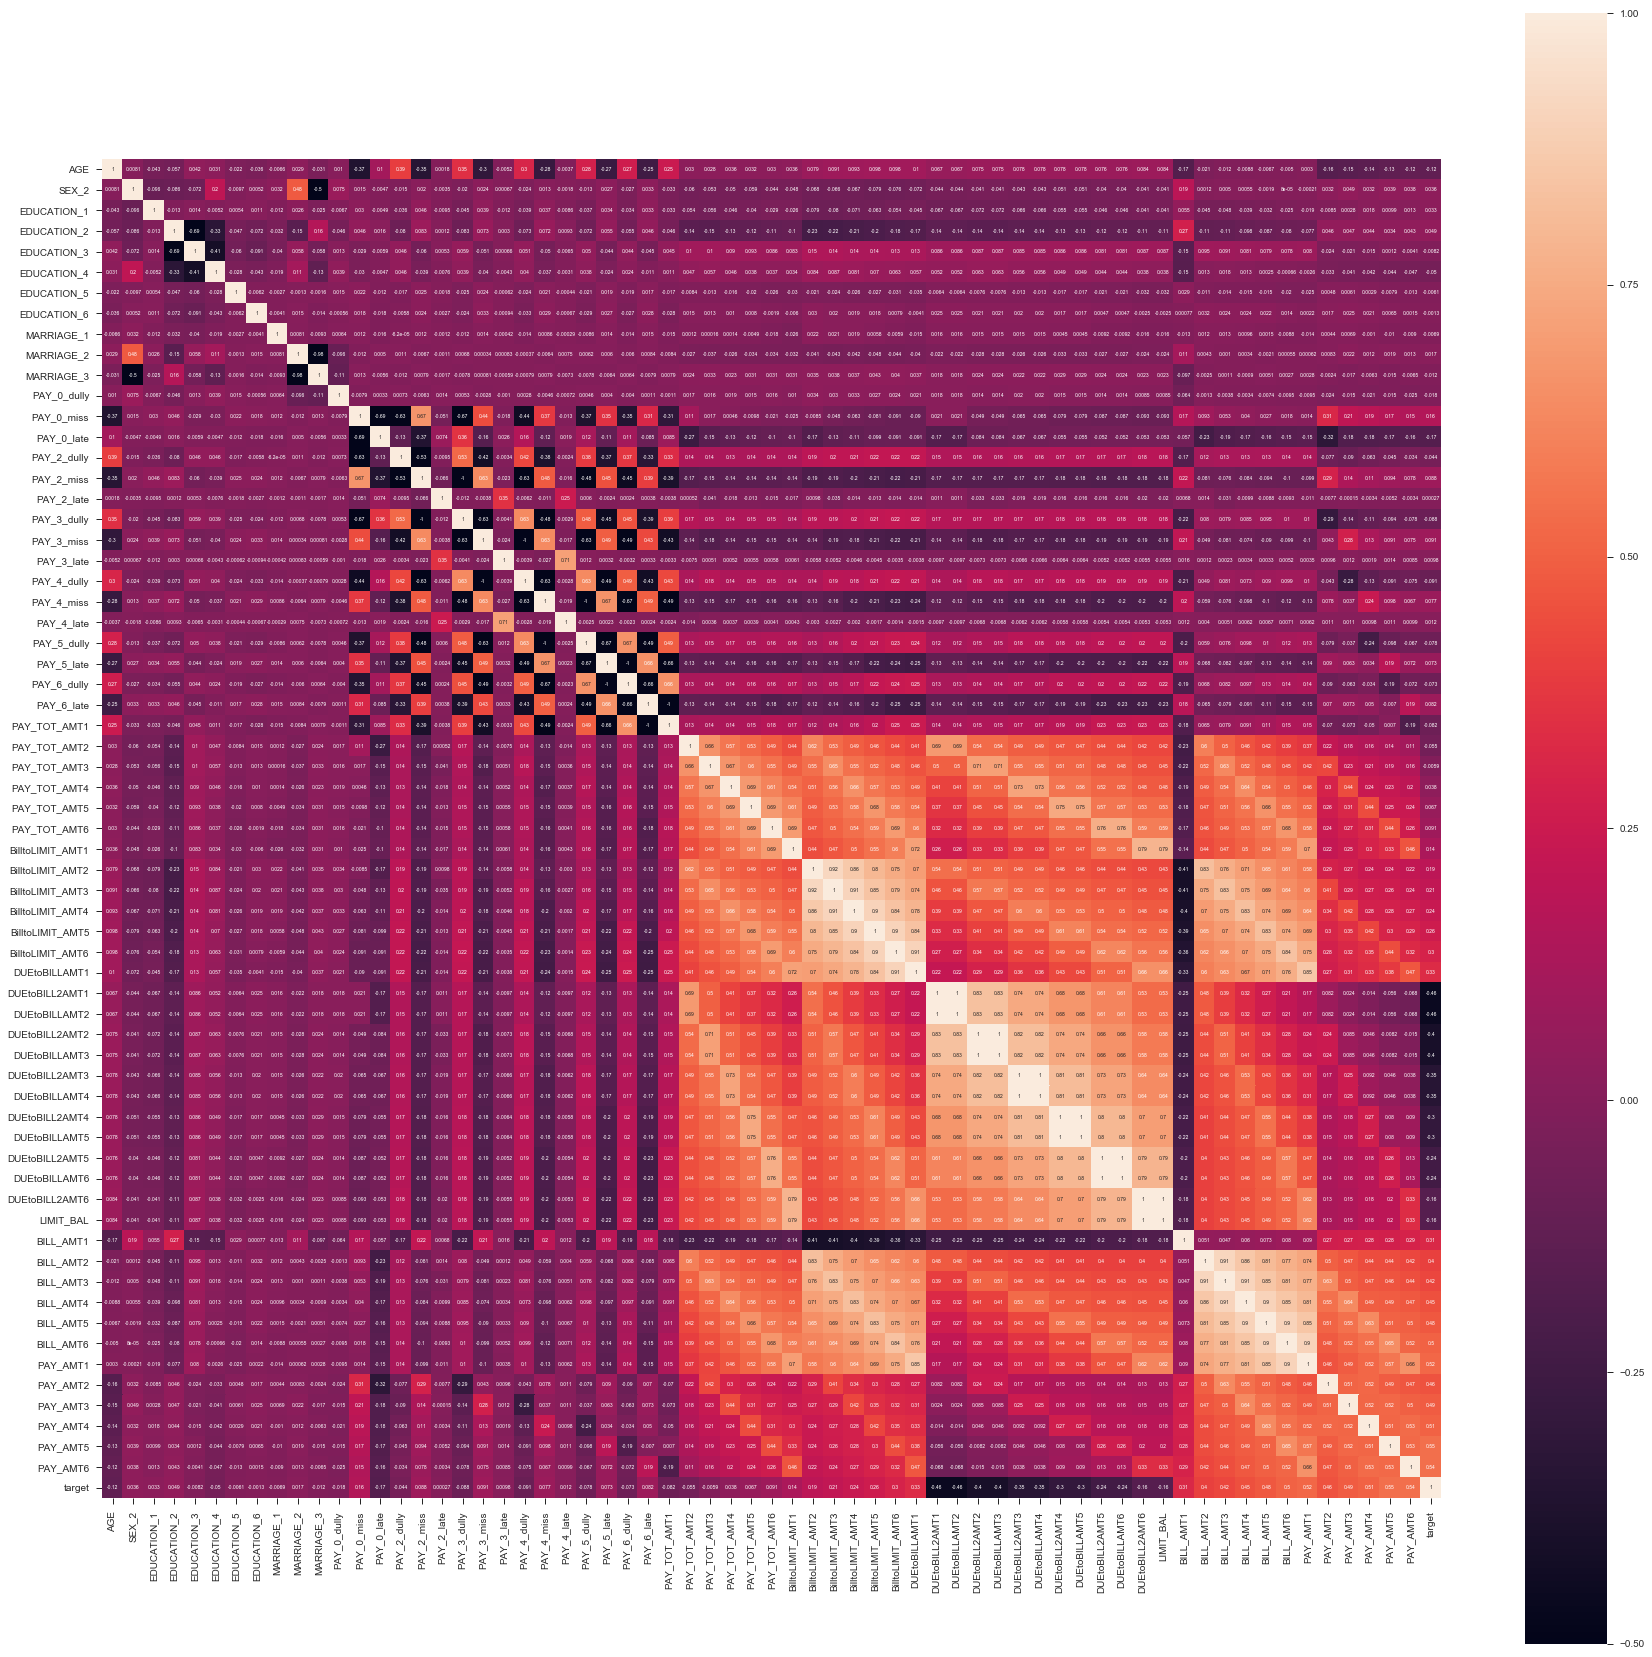

In [20]:
from scipy.stats import spearmanr

rho, pval = spearmanr(Y_train,X_train,axis=0)

#corr = np.corrcoef(data,rowvar=False)
#corr = corr**2
#center = np.average(corr)

#print(corr)
plt.figure(figsize=(30,30))
ax = sns.heatmap(rho,vmax=1.0,vmin=-0.5, square=True,xticklabels=columns_eval,yticklabels=columns_eval,annot=True, annot_kws={"size": 5})
plt.show()



Dado que existem variáveis com correlação positiva e negativa, a interpretação não fica clara.
Vamos repetir o Heatmap com o Rho com todos os valores positivos.

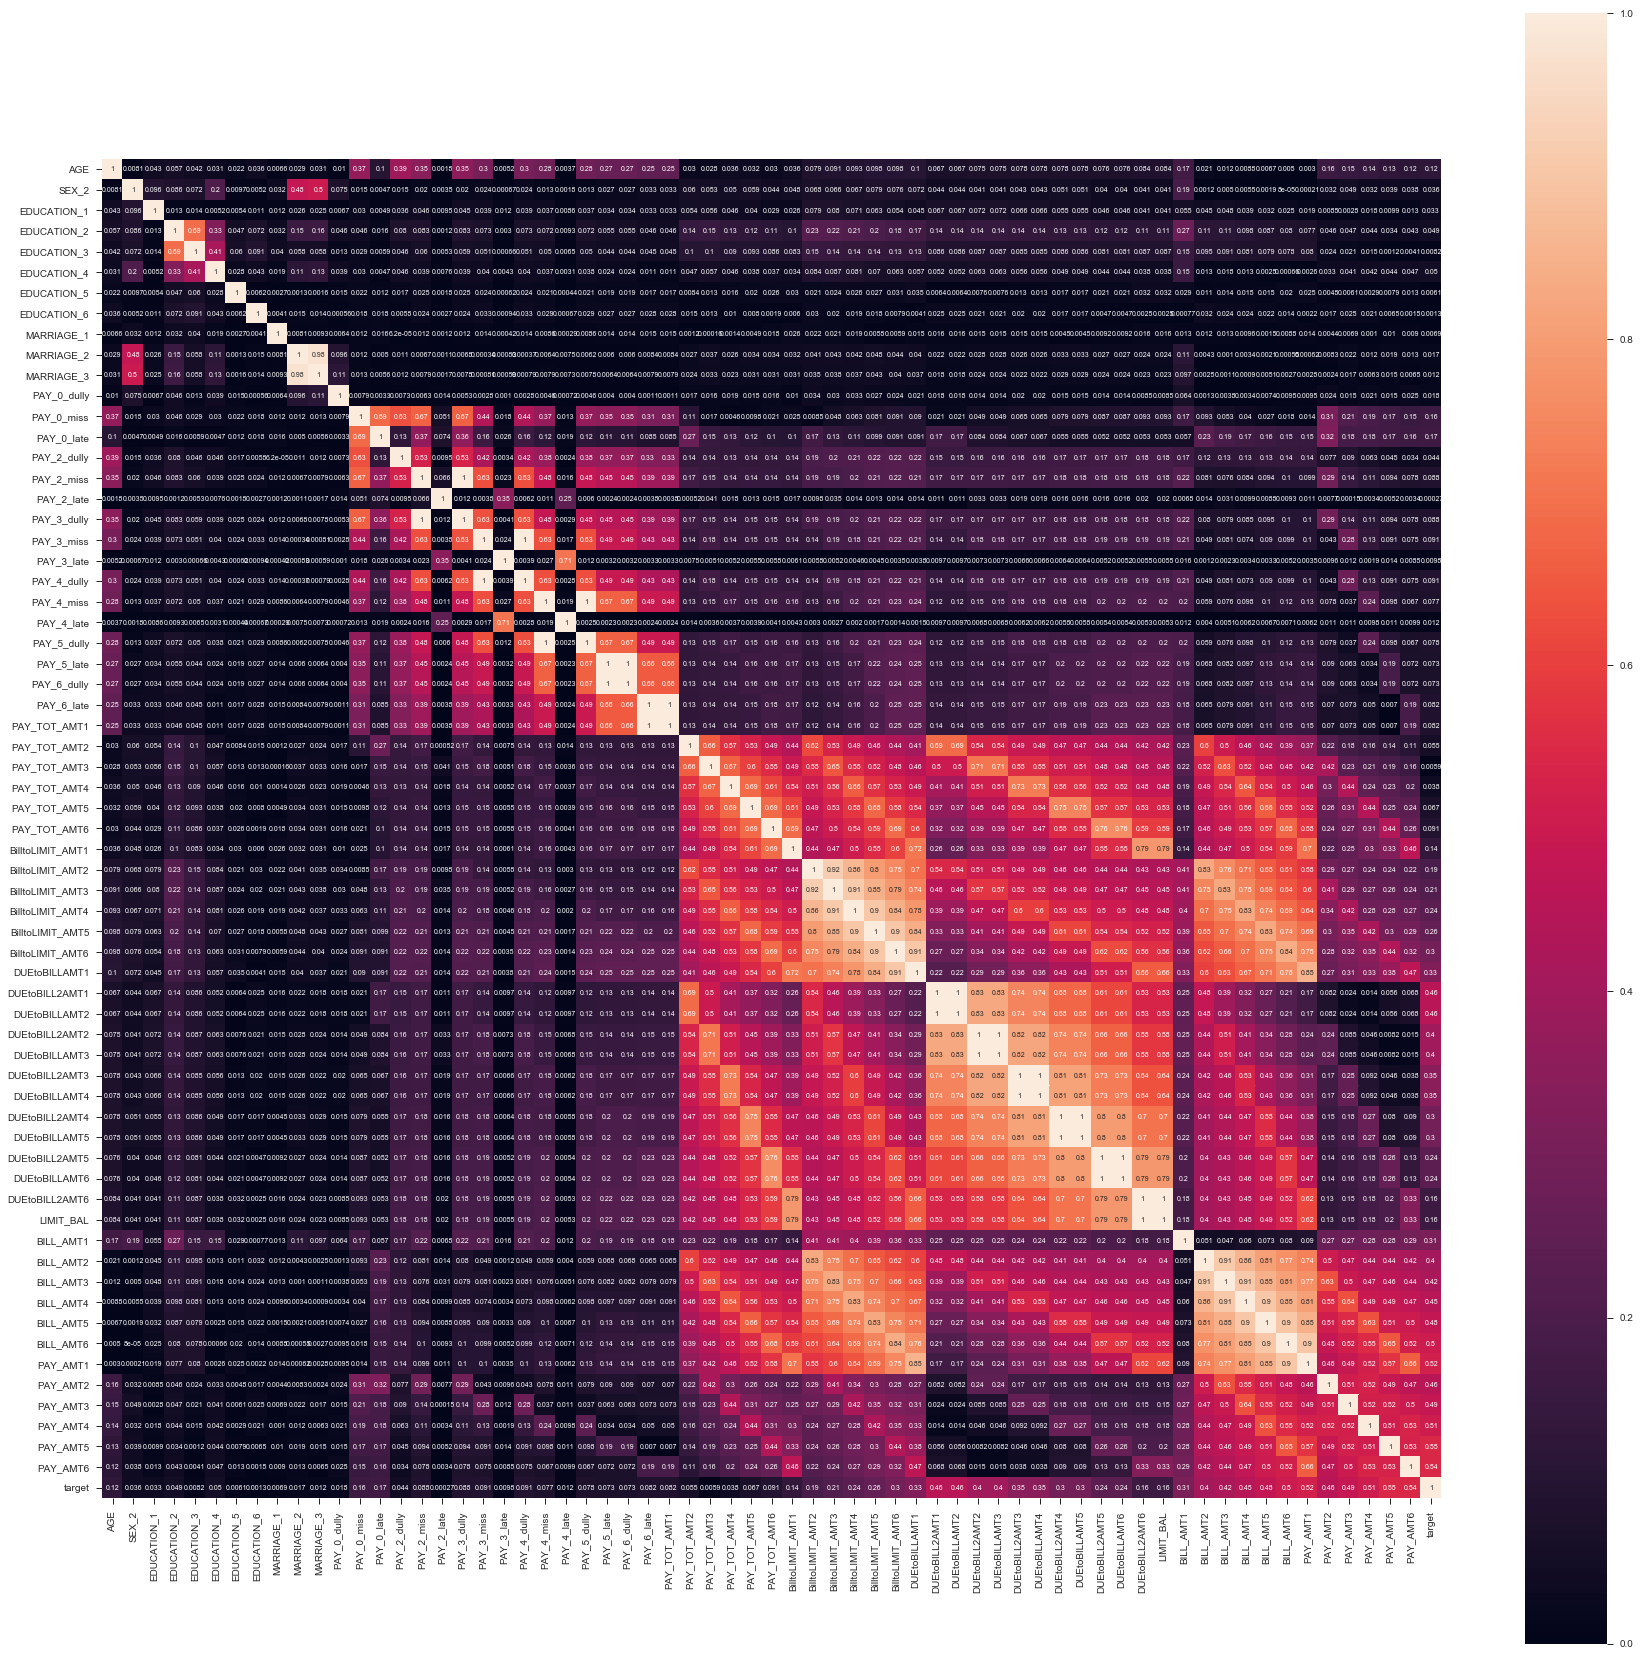

In [21]:
rho_adj = rho**2
rho_adj = np.sqrt(rho_adj)

plt.figure(figsize=(30,30))
ax = sns.heatmap(rho_adj,vmax=1,vmin=0, square=True,xticklabels=columns_eval,yticklabels=columns_eval,annot=True, annot_kws={"size": 7})
plt.show()

In [22]:
rho_class = np.vstack((columns_eval,rho[:,-1]))
rho_class = rho_class.T
rho_class = pd.DataFrame(rho_class).sort_values(1)
rho_class = rho_class.rename({0: 'Variable', 1: 'Spearman_Correlation'},axis=1)
#rho_class = rho_class[['0:Variable','1:Pearson_Correlation']]
print(rho_class)


            Variable    Spearman_Correlation
7        EDUCATION_6  -0.0012766304736556734
29      PAY_TOT_AMT3   -0.005871321886479249
6        EDUCATION_5  -0.0061108643734350725
8         MARRIAGE_1   -0.006949513191659894
4        EDUCATION_3    -0.00821432564760225
10        MARRIAGE_3   -0.011756980051757324
11       PAY_0_dully   -0.017574698697415715
14       PAY_2_dully    -0.04411020846115641
5        EDUCATION_4    -0.05017383489187222
28      PAY_TOT_AMT2    -0.05479315823243535
25       PAY_6_dully    -0.07311171129823747
23       PAY_5_dully    -0.07768214954937741
27      PAY_TOT_AMT1    -0.08240245049087172
17       PAY_3_dully    -0.08818938393235984
20       PAY_4_dully    -0.09090376026522386
0                AGE    -0.12392488447987972
50    DUEtoBILL2AMT6    -0.16161392287565907
51         LIMIT_BAL    -0.16161392287565907
13        PAY_0_late    -0.16622189109240562
48    DUEtoBILL2AMT5    -0.23892715743847678
49     DUEtoBILLAMT6    -0.23892715743847678
46    DUEt

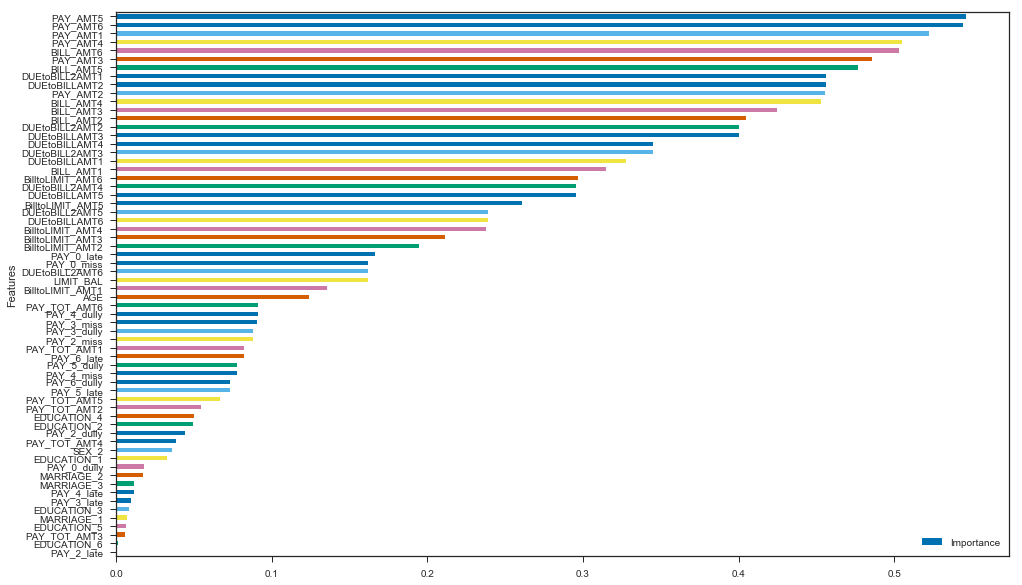

In [24]:
# To plot the importance of the variable, we will make all values positive ( for easier comparability) using rho_adj
rho_adj_sel = np.vstack((columns_eval,rho_adj[:,-1]))
rho_adj_sel = rho_adj_sel[:,:-1]
rho_adj_sel = rho_adj_sel.T
#print(rho_adj_sel)
rho_adj_sel = pd.DataFrame(rho_adj_sel,columns=['Features','Importance']).sort_values('Importance')
rho_adj_sel['Importance'] = rho_adj_sel['Importance'].astype(float)
rho_adj_sel.plot(x='Features',y='Importance',kind='barh')

plt.show()

## Seleção por Regressão Logística com Regularização L1 (Lasso)

In [25]:
#from sklearn.model_selection import train_test_split
#X_train, X_middle, Y_train, Y_middle = train_test_split(data_X,data_Y,test_size=0.3,random_state=42)

In [26]:
# Selecionar variaveis pelo lasso
from sklearn.linear_model import LogisticRegression
C_ranges = [10,1,0.1,0.05,0.01,0.005,0.001,0.0005]
#C_ranges = [0.0001]

lasso_selection = pd.DataFrame(X_train.columns)
#lasso_selection = lasso_selection[:-1] # Retirando a variável resposta 'Ammount'
print(lasso_selection.shape)
#print(lasso_2)
#lasso_2 = np.hstack((lasso_selection,lasso_selection))

(64, 1)


In [27]:
#Selecionando o range de penalidades do L1. Quando menor, mais restritivo fica o modelo e menos vari
for ci in C_ranges:
    model = LogisticRegression(penalty='l1', tol=0.0001, C=ci,fit_intercept=True, intercept_scaling=1, class_weight=None, random_state=42, solver='liblinear', max_iter=1000)
    model.fit(X_train,Y_train)
    lasso_selection= np.hstack((lasso_selection,model.coef_.T))


C:\Users\Rodrigo\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [28]:
#lasso_selection.T
#lasso_selection = np.vstack((X_train.columns,lasso_selection))
#lasso_selection.shape
lasso_selection = pd.DataFrame(lasso_selection)
print(lasso_selection)

                   0            1           2           3           4  \
0                AGE   0.00531315  0.00528305  0.00565671  0.00595707   
1              SEX_2    -0.137467   -0.136812   -0.124417   -0.110196   
2        EDUCATION_1     0.530941    0.292117   0.0209416           0   
3        EDUCATION_2     0.553204    0.314441   0.0509135   0.0325438   
4        EDUCATION_3     0.490753     0.24762           0           0   
5        EDUCATION_4    -0.161458   -0.263824           0           0   
6        EDUCATION_5    -0.743902   -0.903274   -0.549515  -0.0839352   
7        EDUCATION_6     0.106938           0           0           0   
8         MARRIAGE_1     0.852516    0.157071   0.0971041   0.0867838   
9         MARRIAGE_2     0.698386  0.00208725  -0.0354499  -0.0248777   
10        MARRIAGE_3     0.850186    0.128473           0           0   
11       PAY_0_dully    -0.588487   -0.577149   -0.612577   -0.640795   
12        PAY_0_miss    -0.016056           0      

In [29]:
# Creating a visualization
lasso_selection_data = lasso_selection.drop(0,axis=1)
weights = pd.DataFrame(np.arange(len(C_ranges))+1)
#print(weights.shape)
lasso_selection_wa = np.dot(lasso_selection_data,weights)
#lasso_selection_wa = (lasso_selection_wa ** 2) **0.5
lasso_selection_wa = np.hstack((pd.DataFrame(X_train.columns),lasso_selection_wa))
print(lasso_selection_wa)


[['AGE' -0.30254175666904737]
 ['SEX_2' -1.2892058734255674]
 ['EDUCATION_1' 1.1779988346554808]
 ['EDUCATION_2' 1.4650012061045496]
 ['EDUCATION_3' 0.9859932069415431]
 ['EDUCATION_4' -0.6891065063542203]
 ['EDUCATION_5' -4.534734948298142]
 ['EDUCATION_6' 0.10693777005362494]
 ['MARRIAGE_1' 1.8051048555979312]
 ['MARRIAGE_2' 0.42115245073193913]
 ['MARRIAGE_3' 1.1071318952554932]
 ['PAY_0_dully' -20.463489138608736]
 ['PAY_0_miss' -0.016055951597542042]
 ['PAY_0_late' 22.962664431260013]
 ['PAY_2_dully' -4.333886214221401]
 ['PAY_2_miss' 0.22067126996861086]
 ['PAY_2_late' 1.5818743544679257]
 ['PAY_3_dully' -7.835107425168449]
 ['PAY_3_miss' -2.6105465196472175]
 ['PAY_3_late' -0.9646998681048595]
 ['PAY_4_dully' -4.004698722208525]
 ['PAY_4_miss' 0.0]
 ['PAY_4_late' 0.9200821967592783]
 ['PAY_5_dully' -2.7370404073116084]
 ['PAY_5_late' 0.09841904213240489]
 ['PAY_6_dully' -4.455012483842138]
 ['PAY_6_late' 1.3014605780281545]
 ['PAY_TOT_AMT1' -0.5523410833435805]
 ['PAY_TOT_AMT2' 

In [30]:
lasso_selection_wa2 = (((np.dot(lasso_selection_data,weights))**2)**0.5)
lasso_selection_wa2 = np.hstack((pd.DataFrame(X_train.columns),lasso_selection_wa2))
lasso_selection_wa2 = pd.DataFrame(lasso_selection_wa2,columns=['Features','Importance']).sort_values('Importance')
print(lasso_selection_wa2)

            Features  Importance
21        PAY_4_miss           0
56         BILL_AMT5  0.00287293
12        PAY_0_miss    0.016056
44    DUEtoBILL2AMT3   0.0207161
61          PAY_AMT4   0.0352771
39     DUEtoBILLAMT1   0.0511531
49     DUEtoBILLAMT6   0.0512436
43     DUEtoBILLAMT3   0.0737494
55         BILL_AMT4   0.0933615
24        PAY_5_late    0.098419
7        EDUCATION_6    0.106938
60          PAY_AMT3    0.136756
46    DUEtoBILL2AMT4    0.148594
47     DUEtoBILLAMT5     0.14909
29      PAY_TOT_AMT3    0.152218
52         BILL_AMT1    0.202549
15        PAY_2_miss    0.220671
42    DUEtoBILL2AMT2    0.220827
36  BilltoLIMIT_AMT4    0.248495
53         BILL_AMT2    0.287897
0                AGE    0.302542
62          PAY_AMT5    0.385178
37  BilltoLIMIT_AMT5    0.409959
9         MARRIAGE_2    0.421152
50    DUEtoBILL2AMT6    0.471757
45     DUEtoBILLAMT4    0.497682
48    DUEtoBILL2AMT5     0.53677
40    DUEtoBILL2AMT1    0.549988
27      PAY_TOT_AMT1    0.552341
35  Billto

In [31]:
#Variável que recebeu zero em todos os modelos
print('variável igual a zero= ',lasso_selection_wa[lasso_selection_wa[:,1]==0])
print('=============================')
#Variável abaixo de 0.1
print('variável menor que 0.1= ',lasso_selection_wa[lasso_selection_wa[:,1]<=0.1])
print('=============================')
#Variáveis mais importantes
print('variável maior que 1= ',lasso_selection_wa[lasso_selection_wa[:,1]>=1])
#lasso_selection_wa[:,1]

variável igual a zero=  [['PAY_4_miss' 0.0]]
variável menor que 0.1=  [['AGE' -0.30254175666904737]
 ['SEX_2' -1.2892058734255674]
 ['EDUCATION_4' -0.6891065063542203]
 ['EDUCATION_5' -4.534734948298142]
 ['PAY_0_dully' -20.463489138608736]
 ['PAY_0_miss' -0.016055951597542042]
 ['PAY_2_dully' -4.333886214221401]
 ['PAY_3_dully' -7.835107425168449]
 ['PAY_3_miss' -2.6105465196472175]
 ['PAY_3_late' -0.9646998681048595]
 ['PAY_4_dully' -4.004698722208525]
 ['PAY_4_miss' 0.0]
 ['PAY_5_dully' -2.7370404073116084]
 ['PAY_5_late' 0.09841904213240489]
 ['PAY_6_dully' -4.455012483842138]
 ['PAY_TOT_AMT1' -0.5523410833435805]
 ['PAY_TOT_AMT2' -3.7631184210216246]
 ['PAY_TOT_AMT4' -0.9856122716734361]
 ['PAY_TOT_AMT5' -2.0149346400961403]
 ['PAY_TOT_AMT6' -1.0799654483946521]
 ['BilltoLIMIT_AMT1' -1.549834165743213]
 ['BilltoLIMIT_AMT3' -0.5571384966187576]
 ['BilltoLIMIT_AMT5' -0.40995882173474424]
 ['DUEtoBILLAMT1' 0.05115306762907095]
 ['DUEtoBILL2AMT1' -0.5499882632628238]
 ['DUEtoBILL2AMT2

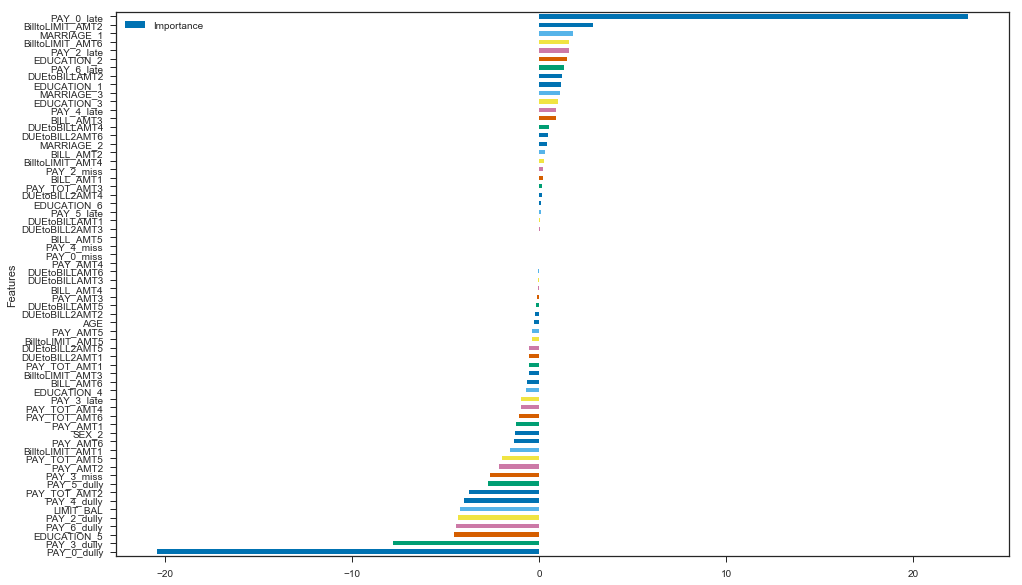

In [32]:
lasso_selection_wa = pd.DataFrame(lasso_selection_wa,columns=['Features','Importance']).sort_values('Importance')
lasso_selection_wa.plot(x='Features',y='Importance',kind='barh')
plt.show()

In [33]:
lr_balanced = LogisticRegression(penalty='l1', tol=0.0001, C=5,fit_intercept=True, intercept_scaling=1, class_weight='balanced', random_state=42, solver='liblinear', max_iter=1000)
lr_balanced.fit(X_train,Y_train)

lr = LogisticRegression(penalty='l1', tol=0.0001, C=5,fit_intercept=True, intercept_scaling=1, class_weight=None, random_state=42, solver='liblinear', max_iter=1000)
lr.fit(X_train,Y_train)

C:\Users\Rodrigo\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(C=5, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=1000, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=42, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [34]:
#Tentando a 1a previsão com a regressão logística (sem balanceamento)
y_train_pred = lr.predict(X_train)
#y_cv_pred = model.predict(X_cv)
y_test_pred = lr.predict(X_test)

print(str(f1_score(Y_train,y_train_pred)),' é o f1 do training set')
#print(str(f1_score(Y_cv,y_cv_pred)), ' é o f1 do validation set')
print(str(f1_score(Y_test,y_test_pred)), ' é o f1 do test set')

print(str(accuracy_score(Y_train,y_train_pred)),' é o accuracy do training set')
#print(str(accuracy_score(Y_cv,y_cv_pred)), ' é o accuracy do validation set')
print(str(accuracy_score(Y_test,y_test_pred)), ' é o accuracy do test set')

print(str(precision_score(Y_train,y_train_pred)),' é o precision do training set')
#print(str(precision_score(Y_cv,y_cv_pred)), ' é o precision do validation set')
print(str(precision_score(Y_test,y_test_pred)), ' é o precision do test set')

print(str(recall_score(Y_train,y_train_pred)),' é o recall do training set')
#print(str(recall_score(Y_cv,y_cv_pred)), ' é o recall do validation set')
print(str(recall_score(Y_test,y_test_pred)), ' é o recall do test set')

print(str(roc_auc_score(Y_train,y_train_pred)),' é o roc_auc do training set')
#print(str(roc_auc_score(Y_cv,y_cv_pred)), ' é o roc_auc do validation set')
print(str(roc_auc_score(Y_test,y_test_pred)), ' é o roc_auc do test set')

0.464331300525  é o f1 do training set
0.419467787115  é o f1 do test set
0.820142857143  é o accuracy do training set
0.815777777778  é o accuracy do test set
0.689263157895  é o precision do training set
0.668526785714  é o precision do test set
0.350085543199  é o recall do training set
0.305612244898  é o recall do test set
0.652438017863  é o roc_auc do training set
0.631712372449  é o roc_auc do test set


In [35]:
#Tentando a 1a previsão com a regressão logística (com balanceamento)
y_train_pred = lr_balanced.predict(X_train)
#y_cv_pred = model.predict(X_cv)
y_test_pred = lr_balanced.predict(X_test)

print(str(f1_score(Y_train,y_train_pred)),' é o f1 do training set')
#print(str(f1_score(Y_cv,y_cv_pred)), ' é o f1 do validation set')
print(str(f1_score(Y_test,y_test_pred)), ' é o f1 do test set')

print(str(accuracy_score(Y_train,y_train_pred)),' é o accuracy do training set')
#print(str(accuracy_score(Y_cv,y_cv_pred)), ' é o accuracy do validation set')
print(str(accuracy_score(Y_test,y_test_pred)), ' é o accuracy do test set')

print(str(precision_score(Y_train,y_train_pred)),' é o precision do training set')
#print(str(precision_score(Y_cv,y_cv_pred)), ' é o precision do validation set')
print(str(precision_score(Y_test,y_test_pred)), ' é o precision do test set')

print(str(recall_score(Y_train,y_train_pred)),' é o recall do training set')
#print(str(recall_score(Y_cv,y_cv_pred)), ' é o recall do validation set')
print(str(recall_score(Y_test,y_test_pred)), ' é o recall do test set')

print(str(roc_auc_score(Y_train,y_train_pred)),' é o roc_auc do training set')
#print(str(roc_auc_score(Y_cv,y_cv_pred)), ' é o roc_auc do validation set')
print(str(roc_auc_score(Y_test,y_test_pred)), ' é o roc_auc do test set')

0.540060505514  é o f1 do training set
0.50437907029  é o f1 do test set
0.775571428571  é o accuracy do training set
0.754777777778  é o accuracy do test set
0.496679231736  é o precision do training set
0.450461291617  é o precision do test set
0.591745081266  é o recall do training set
0.572959183673  é o recall do test set
0.709986728332  é o roc_auc do training set
0.689178455473  é o roc_auc do test set


Nas variáveis agregadas como a área da curva ROC e o F1 Score, o modelo balanceado se saiu melhor. Especialmente por ter tido um score de recall bem mais elevado.

# Testando métodos de Árvore

Como faremos um GridSearch, dividiremos a amostra em Train, CV(Cross validation) e Teste
Como a amostra é muito pequena, deixaremos 20% para o CV e 10% para o teste.

A 3a divisão é nescessária para evitar que tenhamos um overfit do CV ao fazer o GridSearch dos hiperparametros.
Faremos uma abordagem similar à regressão logística usando com K-fold e Grid Search para encontrar os melhores parâmetros

In [36]:
# Para comaçar, dividimos as amostras nos três grupos
#from sklearn.model_selection import train_test_split
#X_train, X_middle, Y_train, Y_middle = train_test_split(data_X,data_Y,test_size=0.3,random_state=42)
#X_cv, X_test, Y_cv, Y_test = train_test_split(X_middle,Y_middle,test_size=(1/3),random_state=42)

In [37]:
# Primeiramente, vamos fazer uma análise descritiva das variáveis usando uma random forest
# Assim, conseguiremos descobrir quais as variáveis mais importantes;
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification

model = RandomForestClassifier(n_estimators=100, criterion='gini',max_features=0.8, max_depth=10, min_samples_split=200,class_weight='balanced')
model.fit(X_train,Y_train)

C:\Users\Rodrigo\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  import sys


RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=10, max_features=0.8,
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=200, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

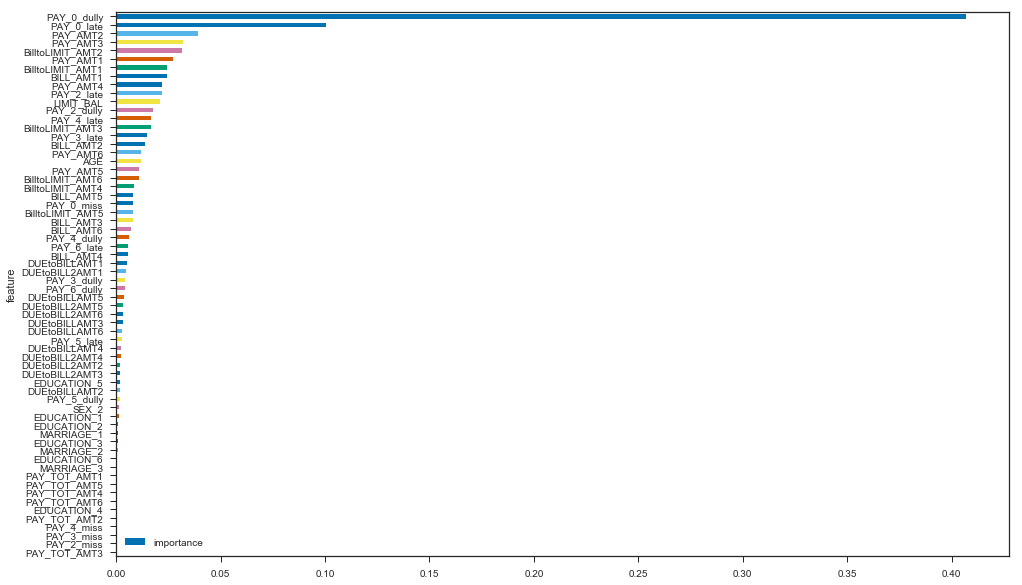

In [38]:
model.feature_importances_
imps = pd.DataFrame({'importance': model.feature_importances_, 'feature': X_train.columns}).sort_values('importance')
                    
imps.plot(x='feature',y='importance',kind='barh')


In [39]:
#Tentando a 1a previsão com random forest
y_train_pred = model.predict(X_train)
#y_cv_pred = model.predict(X_cv)
y_test_pred = model.predict(X_test)

print(str(f1_score(Y_train,y_train_pred)),' é o f1 do training set')
#print(str(f1_score(Y_cv,y_cv_pred)), ' é o f1 do validation set')
print(str(f1_score(Y_test,y_test_pred)), ' é o f1 do test set')

print(str(accuracy_score(Y_train,y_train_pred)),' é o accuracy do training set')
#print(str(accuracy_score(Y_cv,y_cv_pred)), ' é o accuracy do validation set')
print(str(accuracy_score(Y_test,y_test_pred)), ' é o accuracy do test set')

print(str(precision_score(Y_train,y_train_pred)),' é o precision do training set')
#print(str(precision_score(Y_cv,y_cv_pred)), ' é o precision do validation set')
print(str(precision_score(Y_test,y_test_pred)), ' é o precision do test set')

print(str(recall_score(Y_train,y_train_pred)),' é o recall do training set')
#print(str(recall_score(Y_cv,y_cv_pred)), ' é o recall do validation set')
print(str(recall_score(Y_test,y_test_pred)), ' é o recall do test set')

print(str(roc_auc_score(Y_train,y_train_pred)),' é o roc_auc do training set')
#print(str(roc_auc_score(Y_cv,y_cv_pred)), ' é o roc_auc do validation set')
print(str(roc_auc_score(Y_test,y_test_pred)), ' é o roc_auc do test set')

0.591114096536  é o f1 do training set
0.474964904071  é o f1 do test set
0.797095238095  é o accuracy do training set
0.750666666667  é o accuracy do test set
0.536118363795  é o precision do training set
0.438634399309  é o precision do test set
0.658682634731  é o recall do training set
0.517857142857  é o recall do test set
0.747713039982  é o roc_auc do training set
0.666670048701  é o roc_auc do test set


# Comparando os métodos e conclusão

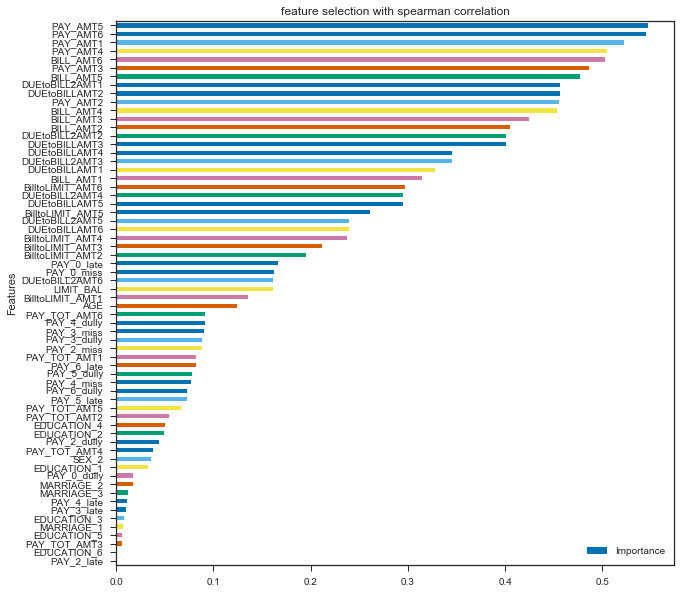

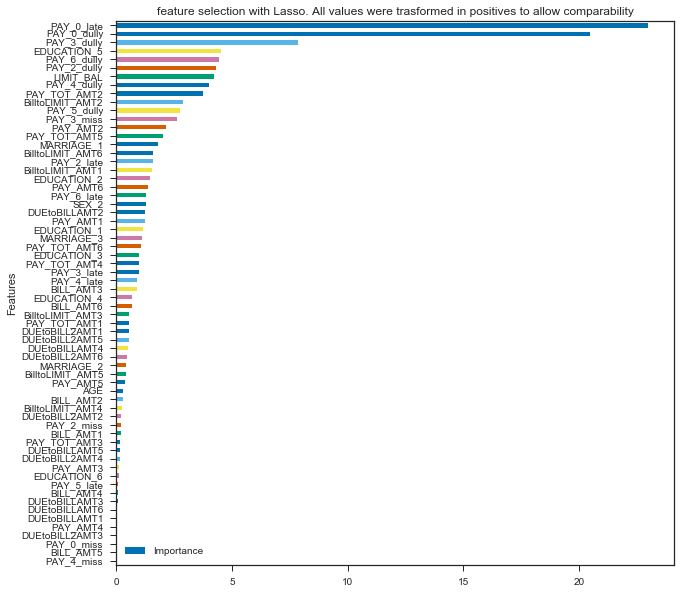

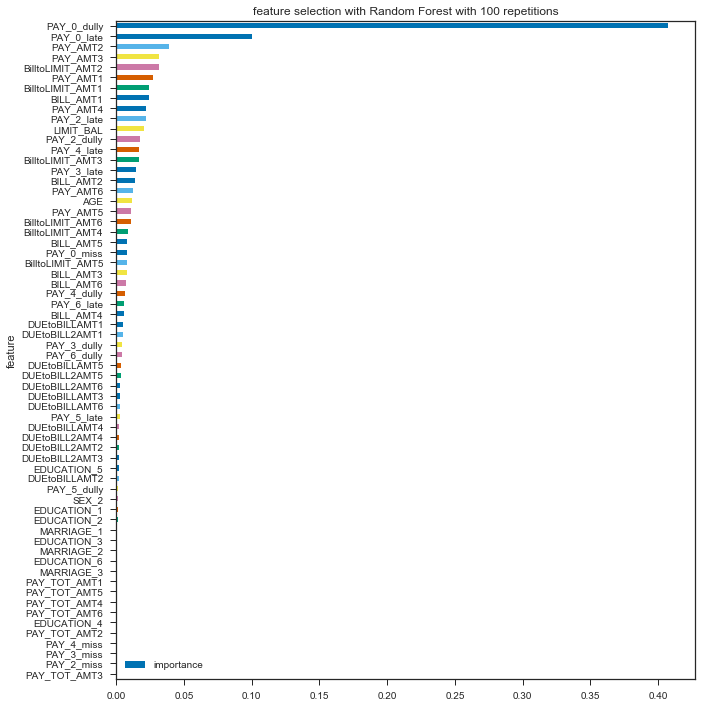

In [41]:
sns.set(style="ticks")
plt.rcParams['figure.figsize'] = (10.0, 10.0)
plt.style.use('seaborn-colorblind')




plt.figure(1)
#plt.subplot(111)
rho_adj_sel.plot(x='Features',y='Importance',kind='barh')
plt.title('feature selection with spearman correlation')

plt.figure(2)
#plt.subplot(122)
#plt.subplot(1, 2, 2)
lasso_selection_wa2.plot(x='Features',y='Importance',kind='barh')#.add_subplot(122)
plt.title('feature selection with Lasso. All values were trasformed in positives to allow comparability')

plt.figure(3)
#plt.subplot(133)
#plt.subplot(1, 3, 3)
imps.plot(x='feature',y='importance',kind='barh') #.add_subplot(123)
plt.title('feature selection with Random Forest with 100 repetitions')
plt.tight_layout()

plt.show()
